In [1902]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import talib as ta
from talib import abstract
import yfinance as yfin
from arch import arch_model
import quantstats

pd.set_option('display.float_format', '{:.2f}'.format)


# dataframe

In [1903]:
# 資料DataFrame
df = yfin.download('^TWII', start = '2022-1-1', end = '2024-7-30')
df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']


[*********************100%%**********************]  1 of 1 completed


# function

In [1904]:
def get_llt(df, a):
    llt = np.zeros(len(df))
    llt[0] = df['close'].iloc[0]
    llt[1] = (1 - a) * df['close'].iloc[0] + a * df['close'].iloc[1]
    for n in range(2, len(df)):
        llt[n] = ((a - (a ** 2)/4) * df['close'].iloc[n]) + (((a ** 2)/2) * df['close'].iloc[n - 1]) - ((a - (3 * (a ** 2))/4) * df['close'].iloc[n - 2]) + ((2 * (1 - a)) * llt[n - 1]) - (((1 - a) ** 2) * llt[n - 2])
    
    df['llt'] = llt
    df['llt_slope'] = np.nan

    for i in range(0, len(df)):
        df.loc[df.index[i], 'llt_slope'] = df['llt'].iloc[i] - df['llt'].iloc[i - 1]
    return df


def bolinger_band(df, p, q, o, rolling, num_vol, upper_threshold, lower_threshold, retrace_u_threshold, retrace_l_threshold):
    model = arch_model(df['llt'].dropna(), vol = 'Garch', p = p, q = q, o = o, rescale = False)
    garch_fit = model.fit(disp = 'off')
    df['garch_volitility'] = garch_fit.conditional_volatility

    df['bolinger_upper'] = df['llt'] + num_vol * df['garch_volitility']
    df['bolinger_lower'] = df['llt'] - num_vol * df['garch_volitility']

    df['bolinger_upper_smooth'] = df['bolinger_upper'].ewm(span = 20).mean()
    df['bolinger_lower_smooth'] = df['bolinger_lower'].ewm(span = 20).mean()

    df['upper_max'] = df['bolinger_upper'].rolling(window = rolling).max()
    df['lower_min'] = df['bolinger_lower'].rolling(window = rolling).min()

    df['upper_retrace'] = (df['upper_max'] - df['bolinger_upper']) / df['upper_max']
    df['lower_retrace'] = (df['bolinger_lower'] - df['lower_min']) / df['lower_min']

    df['upper_deviation'] = (df['bolinger_upper'] - df['close']) / df['close']
    df['lower_deviation'] = (df['close'] - df['bolinger_lower']) / df['close']

    df['upper_rise'] = df['upper_deviation'] >= upper_threshold
    df['lower_down'] = df['lower_deviation'] >= lower_threshold
    df['upper_down'] = df['upper_retrace'] >= retrace_u_threshold
    df['lower_rise'] = df['lower_retrace'] >= retrace_l_threshold

    return df

def get_middle(df):
    
    df['middle'] = np.nan
    df.loc[df.index[0], 'middle'] = df['close'].iloc[0]

    for i in range(1, len(df)):

        upper_change = abs(df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1])
        lower_change = abs(df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1])
        
        peak_upward = upper_change > lower_change
        peak_downward = upper_change < lower_change
    
        if peak_upward:
            df.iloc[i, df.columns.get_loc('middle')] = ((df['middle'].iloc[i - 1] * i) + df['bolinger_lower_smooth'].iloc[i]) / (i + 1)
            # df.loc[df.index[i], 'middle'] = ((df['middle'].iloc[i - 1] * (i)) + df['bolinger_lower']) / (i + 1)
        elif peak_downward:
            df.iloc[i, df.columns.get_loc('middle')] = ((df['middle'].iloc[i - 1] * i) + df['bolinger_upper_smooth'].iloc[i]) / (i + 1)
            # df.loc[df.index[i], 'middle'] = ((df['middle'].iloc[i - 1] * (i)) + df['bolinger_upper']) / (i + 1)
    
    return df



# strategy

## long & short


In [1905]:
def llt_strategy(df, fund, feePaid, a, p, q, o, num_vol, upper_threshold, lower_threshold, retrace_u_threshold, retrace_l_threshold):
    
    ret_df = pd.DataFrame(index = df.index)
    equity = pd.DataFrame(index = df.index)
    
    df = get_llt(df, a)
    df = bolinger_band(
        df = df, p = p, q = q, o = o, rolling = rolling, num_vol = num_vol,
        upper_threshold = upper_threshold, lower_threshold = lower_threshold,
        retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold)
    df = get_middle(df)

    BS = None
    t = 0
    df['Bull'] = False
    df['Bear'] = False
    ret_df = ret_df.assign(
        position = np.zeros(len(df)),
        buy = np.zeros(len(df)),
        sell = np.zeros(len(df)),
        sellshort = np.zeros(len(df)),
        buytocover = np.zeros(len(df)),
        buy_price = np.zeros(len(df)),
        sell_price = np.zeros(len(df)),
        short_price = np.zeros(len(df)),
        buytocover_price = np.zeros(len(df)),
        buy_time = np.nan,
        sell_time = np.nan,
        sellshort_time = np.nan,
        buytocover_time = np.nan,
        profit_list = np.zeros(len(df)),
        profit_fee_list = np.zeros(len(df)),
        profit_fee_list_realized = np.zeros(len(df))
    )
    ret_df['buy_time'] = pd.to_datetime(ret_df['buy_time'], errors='coerce')
    ret_df['sell_time'] = pd.to_datetime(ret_df['sell_time'], errors='coerce')
    ret_df['sellshort_time'] = pd.to_datetime(ret_df['sellshort_time'], errors='coerce')
    ret_df['buytocover_time'] = pd.to_datetime(ret_df['buytocover_time'], errors='coerce')

    for i in range(2, len(df) - 1):
        
        condition1 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) > (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向上
        condition2 = (df['bolinger_upper_smooth'].iloc[i] - df['middle'].iloc[i]) < (df['middle'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向下
        condition3 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) > 0 # 上軌向上
        condition4 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) < 0 # 上軌向下
        condition5 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) > 0 # 下軌向上
        condition6 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) < 0 # 下軌向下
        df.at[df.index[i], 'Bull'] = (condition1 & condition3) | (condition2 & condition5)
        df.at[df.index[i], 'Bear'] = (condition1 & condition4) | (condition2 & condition6)

        entryLong = (df['llt_slope'].iloc[i] > 0) & (((df['upper_rise'].iloc[i] == True) & condition1) | ((df['lower_rise'].iloc[i] == True) & condition2))
        exitLong = ((df['bolinger_upper'].iloc[i] < df['bolinger_upper_smooth'].iloc[i]) & condition1 & condition4) | ((df['bolinger_lower'].iloc[i] < df['bolinger_lower_smooth'].iloc[i]) & condition2 & condition6)
        entryShort = (df['llt_slope'].iloc[i] < 0) & (((df['upper_down'].iloc[i] == True) & condition1) | ((df['lower_down'].iloc[i] == True) & condition2))
        exitShort = ((df['bolinger_upper'].iloc[i] > df['bolinger_upper_smooth'].iloc[i]) & condition1 & condition3) | ((df['bolinger_lower'].iloc[i] > df['bolinger_lower_smooth'].iloc[i]) & condition2 & condition5)

        # print(f'{df.index[i]}, state : {BS}, position : {ret_df["position"].iloc[i]}')

        if BS == None:
            if df['Bull'].iloc[i]:
                if entryLong:
                    BS = 'B'
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'buy'] = t
                    ret_df.at[ret_df.index[t], 'buy_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'buy_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] += 1
                    # print(f'entryLong at {df.index[t]}')

            elif df['Bear'].iloc[i]:
                if entryShort:
                    BS = 'S'
                    t = i + 1
                    ret_df.at[ret_df.index[t], 'sellshort'] = t
                    ret_df.at[ret_df.index[t], 'short_price'] = df['open'].iloc[t]
                    ret_df.at[ret_df.index[t], 'sellshort_time'] = df.index[t]
                    ret_df.at[ret_df.index[t], 'position'] -= 1
                    # print(f'entryShort at {df.index[t]}')

        elif BS == 'B':
            
            ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
            ret_df.at[ret_df.index[i], 'profit_list'] = profit

            if exitLong:
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                profit_fee = profit - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'position'] -= 1
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                BS = None

                ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = pl_round - feePaid * 2

            elif i == len(df) - 2:
                if ret_df['position'].iloc[len(df) - 2] != 0:
                    unit = ret_df['position'].iloc[len(df) - 2]
                    profit_fee = profit - feePaid * 2
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    ret_df.at[ret_df.index[i + 1], 'position'] -= unit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'sell_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'sell'] = i + 1
                    BS = None

            else:
                profit_fee = profit
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        elif BS == 'S':
            ret_df.at[ret_df.index[i + 1], 'position'] = ret_df.at[ret_df.index[i], 'position']
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
            ret_df.at[ret_df.index[i], 'profit_list'] = profit

            if exitShort:
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                profit_fee = profit - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'position'] += 1
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                ret_df.at[ret_df.index[i + 1], 'buytocover_price'] = df['open'].iloc[i + 1]
                ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                BS = None

                profit_fee_realized = pl_round - feePaid * 2
                ret_df.at[ret_df.index[i + 1], 'profit_fee_list_realized'] = profit_fee_realized

            elif i == len(df) - 2:
                if ret_df['position'].iloc[len(df) - 2] != 0:
                    unit = ret_df['position'].iloc[len(df) - 2]
                    profit_fee = profit - feePaid * 2
                    pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t]) * ret_df['position'].iloc[i]
                    ret_df.at[ret_df.index[i + 1], 'position'] += unit
                    ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee
                    ret_df.at[ret_df.index[i + 1], 'sell_price'] = df['open'].iloc[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'buytocover_time'] = df.index[i + 1]
                    ret_df.at[ret_df.index[i + 1], 'buytocover'] = i + 1
                    BS = None
            else:
                profit_fee = profit
                ret_df.at[ret_df.index[i], 'profit_fee_list'] = profit_fee

        else:
            print('error')
            
        if t is not None:
            if pd.notna((ret_df['buy_time'].iloc[t]) and pd.notna(ret_df['sell_time'].iloc[i + 1])):
                hold_duration = (ret_df['sell_time'].iloc[i + 1] - ret_df['buy_time'].iloc[t]).days
                ret_df.at[ret_df.index[i + 1], 'hold_duration'] = hold_duration
            elif pd.notna((ret_df['sellshort_time'].iloc[t]) and pd.notna(ret_df['buytocover_time'].iloc[i + 1])):
                hold_duration = (ret_df['sellshort_time'].iloc[i + 1] - ret_df['buytocover_time'].iloc[t]).days
                ret_df.at[ret_df.index[i + 1], 'hold_duration'] = hold_duration
        else:
            print(f"Warning: t is not assigned before using it at index {i}")

        # print(f'Index: {i}, df["Bull"].iloc[i]: {df["Bull"].iloc[i]}, entryLong: {entryLong}, entryShort: {entryShort}')


    df['strategy_ret'] = ret_df['profit_list'].cumsum()
    equity['profitfee'] = ret_df['profit_fee_list'].cumsum()

    return df, ret_df, equity

## parametors

In [1906]:
a = 0.1
p = 1
q = 1
o = 0
num_vol = 1
rolling = 20
upper_threshold = 0.01
lower_threshold = 0.01
retrace_u_threshold = 0.01
retrace_l_threshold = 0.01
fund = 1000000
feePaid = 600

In [1907]:
df, ret_df, equity = llt_strategy(
df, fund = fund, feePaid = feePaid, a = a, p = p, q = q, o = o, num_vol = num_vol,
upper_threshold = upper_threshold, lower_threshold = lower_threshold,
retrace_u_threshold = retrace_u_threshold, retrace_l_threshold = retrace_l_threshold
)

## 指數

In [1908]:
ret_df['index_ret'] = np.zeros(len(df))

for i in range(1, len(df)):
    ret_df.loc[ret_df.index[i], 'index_ret'] = (df['open'].iloc[i] - df['open'].iloc[i - 1]) * 200

ret_df['cum_index_ret'] = ret_df['index_ret'].cumsum()

# performance

In [1909]:
duration = (equity.index[-1] - equity.index[0]).days
risk_free_rate = 0.04/252
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = min((ret_df['buy'] > 0).sum(), (ret_df['sell'] > 0).sum()) + min((ret_df['sellshort'] > 0).sum(), (ret_df['buytocover'] > 0).sum())
winRate = len([i for i in ret_df['profit_fee_list_realized'] if i > 0]) / tradeTimes
try:
    profitFactor = sum([i for i in ret_df['profit_fee_list_realized'] if i>0]) / abs(sum([i for i in ret_df['profit_fee_list_realized'] if i < 0]))
except:
    profitFactor = None
mean_ret = ret_df['profit_list'].mean()
std_ret = ret_df['profit_list'].std()
sharp = (mean_ret - risk_free_rate) / std_ret

print('Duration : ', duration, 'days')
print('Profit : ', profit)
print('Return : ', ret)
print('Max DrawDown : ', mdd)
print('Caimar Ratio : ', calmarRatio)
print('Trade Times : ', tradeTimes)
print('Win Rate : ', winRate)
print('Profit Factor : ', profitFactor)
print('Sharp Ratio : ', sharp)

Duration :  938 days
Profit :  170331.8359375
Return :  0.1703318359374999
Max DrawDown :  0.6120646753258736
Caimar Ratio :  0.2782905839923082
Trade Times :  26
Win Rate :  0.4230769230769231
Profit Factor :  1.1213715318925255
Sharp Ratio :  0.010524595044415032


# plot

## profit

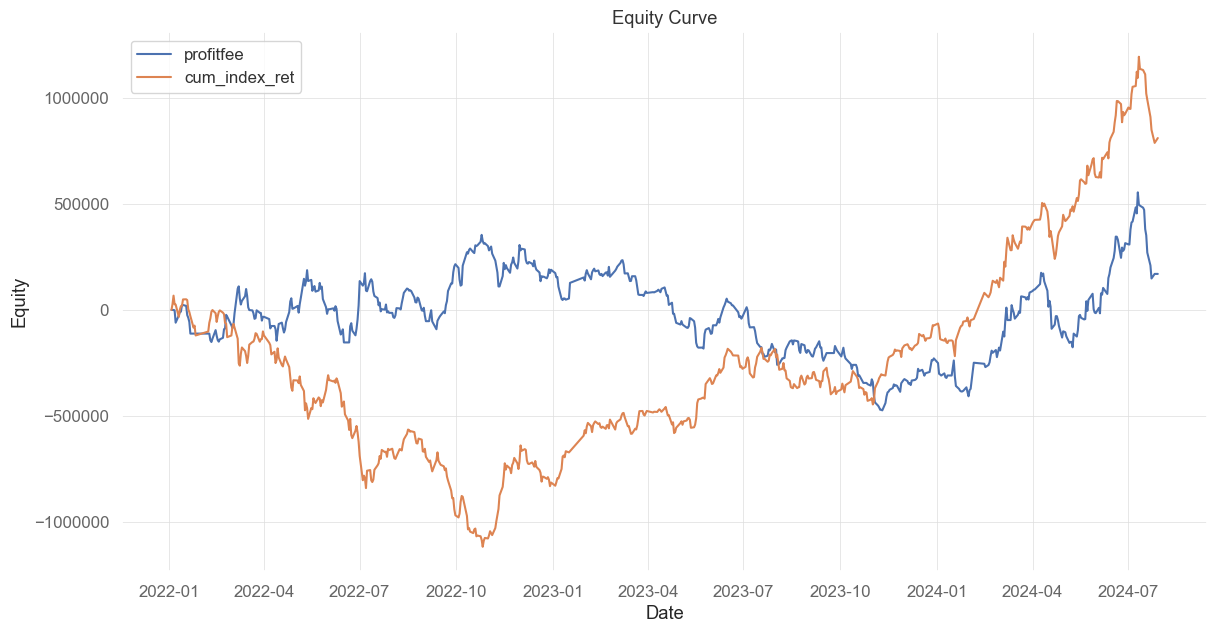

In [1910]:
# plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df.index, equity['profitfee'], label='profitfee')
ax.plot(df.index, ret_df['cum_index_ret'], label='cum_index_ret')

## 设置纵轴刻度格式
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

## 添加网格、标签和标题
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Equity')
ax.set_title('Equity Curve')
ax.legend()

plt.show()


## 買賣點

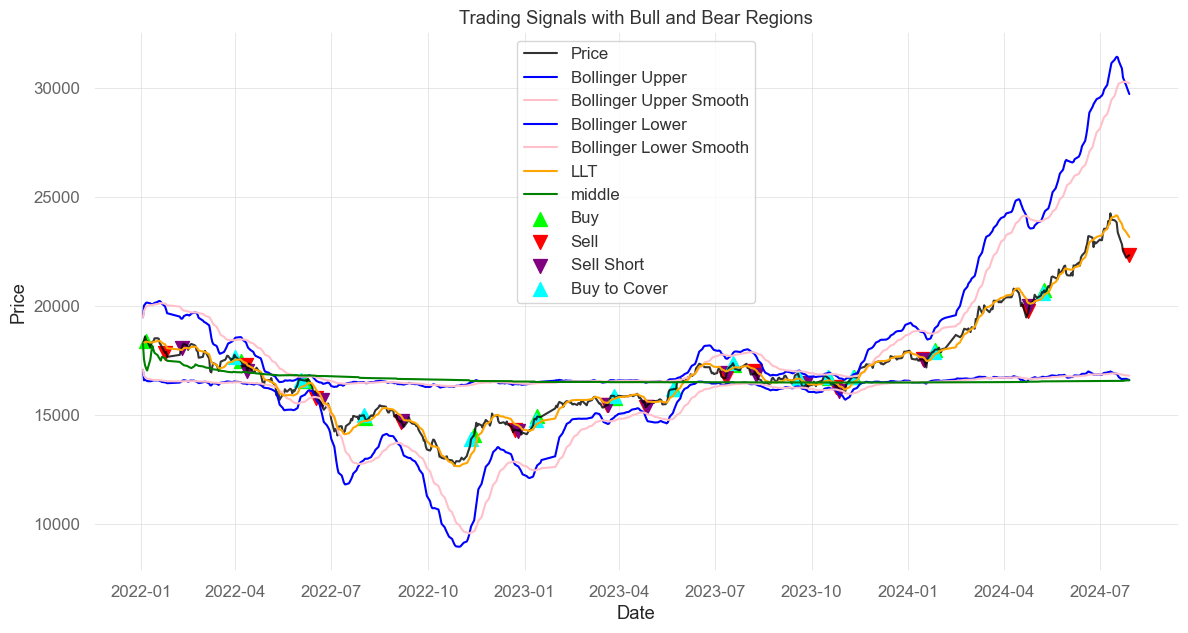

In [1911]:
# 筛选买卖信号
buy_points = ret_df[ret_df['buy'] > 0]
sell_points = ret_df[ret_df['sell'] > 0]
sellshort_points = ret_df[ret_df['sellshort'] > 0]
buytocover_points = ret_df[ret_df['buytocover'] > 0]

# 绘制价格图表
plt.figure(figsize=(14, 7))

# 绘制价格线
plt.plot(df.index, df['open'], label='Price', color='black', alpha=0.8)

# 绘制布林带上轨线
plt.plot(df.index, df['bolinger_upper'], label='Bollinger Upper', color='blue')
plt.plot(df.index, df['bolinger_upper_smooth'], label='Bollinger Upper Smooth', color='pink')

# 绘制布林带下轨线
plt.plot(df.index, df['bolinger_lower'], label='Bollinger Lower', color='blue')
plt.plot(df.index, df['bolinger_lower_smooth'], label='Bollinger Lower Smooth', color='pink')

# 绘制LLT线
plt.plot(df.index, df['llt'], label='LLT', color='orange')

# 绘制中线
plt.plot(df.index, df['middle'], label='middle', color='green')

# # 绘制买入点
plt.scatter(buy_points.index, df['open'].loc[buy_points.index], color='lime', marker='^', label='Buy', s=100)

# # 绘制卖出点
plt.scatter(sell_points.index, df['open'].loc[sell_points.index], color='red', marker='v', label='Sell', s=100)

# # 绘制卖空点
plt.scatter(sellshort_points.index, df['open'].loc[sellshort_points.index], color='purple', marker='v', label='Sell Short', s=100)

# # 绘制买回点
plt.scatter(buytocover_points.index, df['open'].loc[buytocover_points.index], color='cyan', marker='^', label='Buy to Cover', s=100)

# # 绘制 Bull 和 Bear 区域
# bull_region_label_shown = False
# bear_region_label_shown = False
# for i in range(1, len(df)):
#     if df['Bull'].iloc[i]:
#         plt.fill_between(df.index[i-1:i+1], df['open'].min(), df['open'].max(), color='lightgreen', alpha=0.5, label='Bull Region' if not bull_region_label_shown else "")
#         bull_region_label_shown = True
#     if df['Bear'].iloc[i]:
#         plt.fill_between(df.index[i-1:i+1], df['open'].min(), df['open'].max(), color='lightcoral', alpha=0.5, label='Bear Region' if not bear_region_label_shown else "")
#         bear_region_label_shown = True

# 添加图例、标题和标签
plt.legend()
plt.title('Trading Signals with Bull and Bear Regions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


## performance

/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


                           Strategy
-------------------------  ----------
Start Period               2022-01-04
End Period                 2024-07-29
Risk-Free Rate             0.0%
Time in Market             94.0%

Cumulative Return          17.03%
CAGR﹪                     4.32%

Sharpe                     0.38
Prob. Sharpe Ratio         72.41%
Smart Sharpe               0.34
Sortino                    0.58
Smart Sortino              0.52
Sortino/√2                 0.41
Smart Sortino/√2           0.37
Omega                      1.07

Max Drawdown               -61.21%
Longest DD Days            616
Volatility (ann.)          50.9%
Calmar                     0.07
Skew                       0.6
Kurtosis                   3.02

Expected Daily %           0.03%
Expected Monthly %         0.51%
Expected Yearly %          5.38%
Kelly Criterion            3.13%
Risk of Ruin               0.0%
Daily Value-at-Risk        -5.2%
Expected Shortfall (cVaR)  -5.2%

Max Consecutive Wins       7
Max

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-10-26,2023-11-10,2024-07-02,616,-61.21,-58.65
2,2022-05-13,2022-06-16,2022-09-28,139,-28.74,-25.91
3,2024-07-11,2024-07-23,2024-07-29,19,-26.16,-24.77
4,2022-03-09,2022-04-13,2022-05-06,59,-23.11,-19.63
5,2022-01-17,2022-02-10,2022-03-04,47,-17.07,-16.90


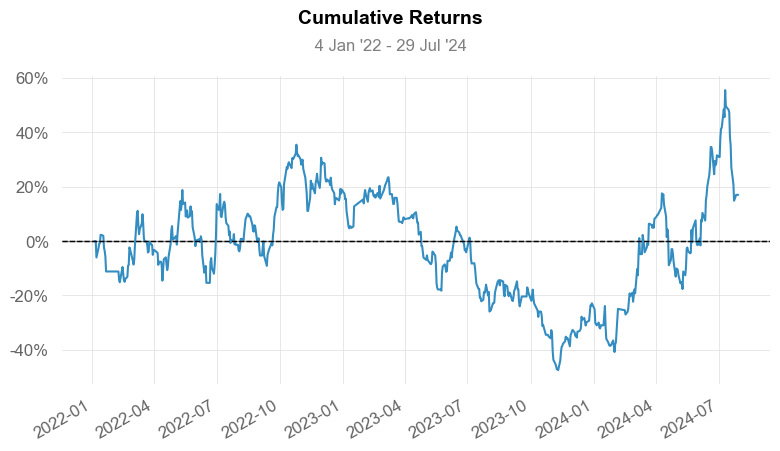

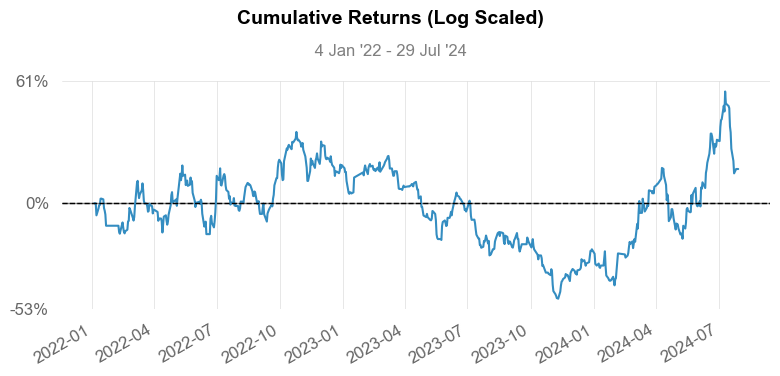

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


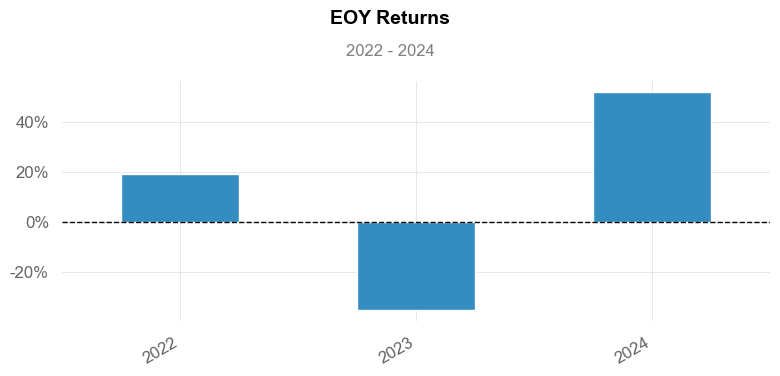

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


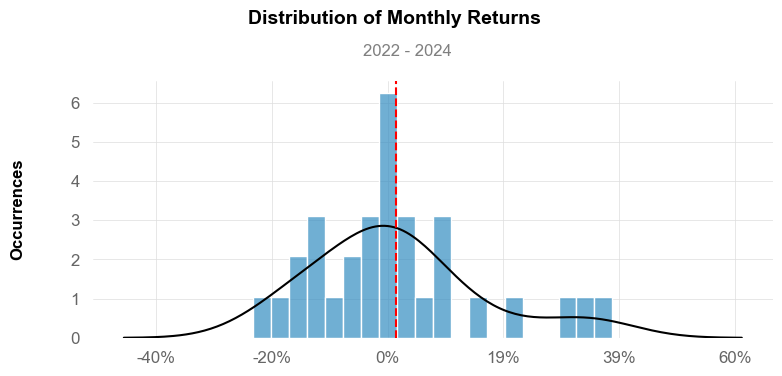

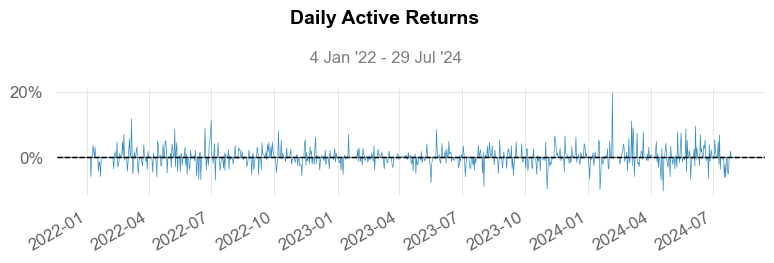

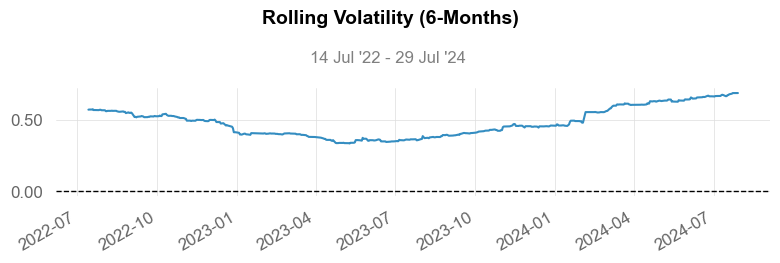

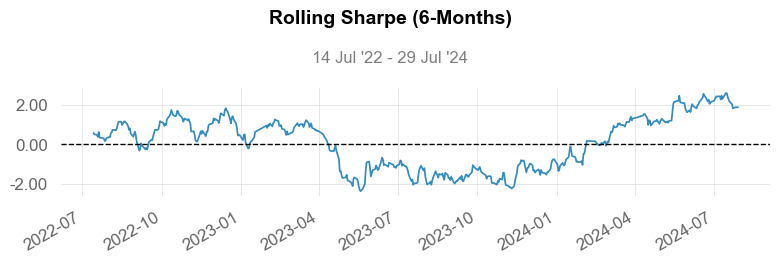

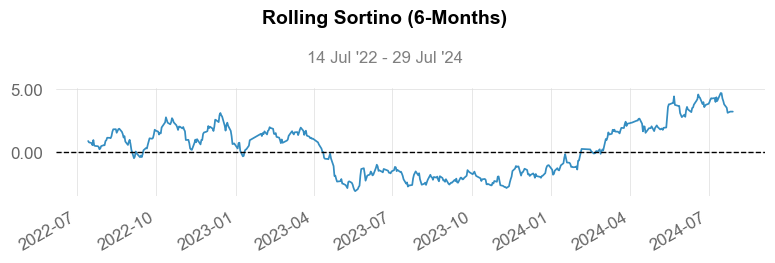

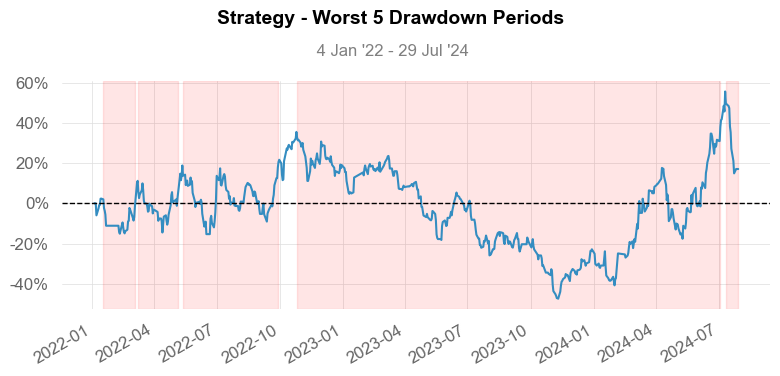

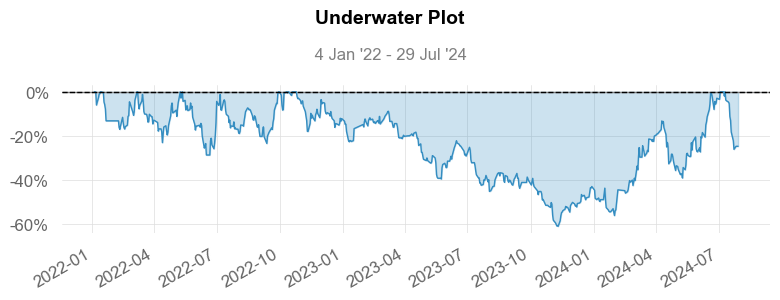

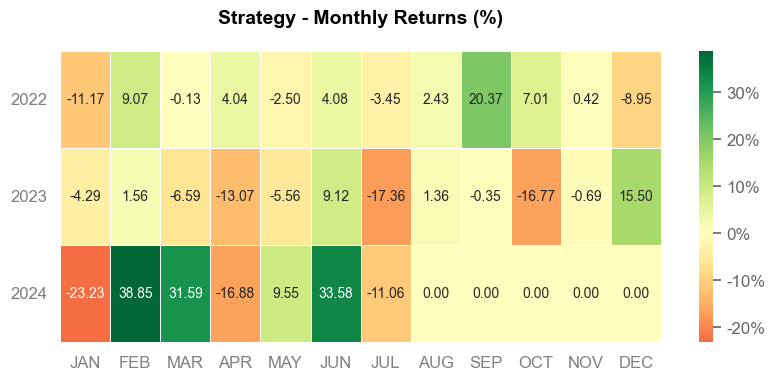

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1021: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  port["Quarterly"] = port["Daily"].resample("Q").apply(apply_fnc)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1024: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  port["Yearly"] = port["Daily"].resample("A").apply(apply_fnc)


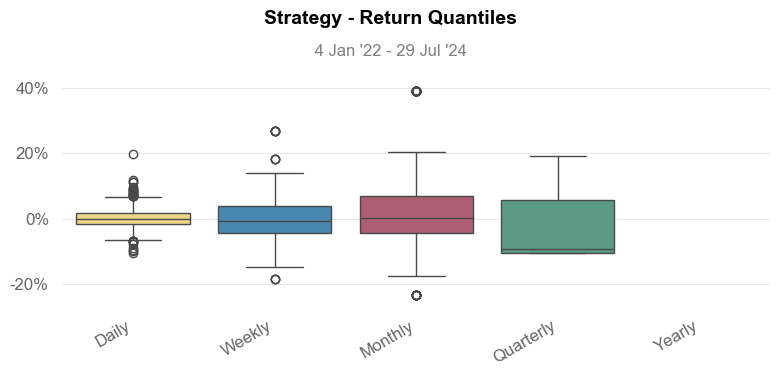

In [1912]:
ret = equity['equity'].pct_change(periods=1).dropna()
quantstats.reports.full(ret)

In [1913]:
print(train_df['llt'].dtype)
print(train_df['garch_volitility'].dtype)


float64
float64


In [1914]:
df.to_csv('df.csv')
ret_df.to_csv('ret_df.csv')